In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-11-2022)


In [2]:
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from gammapy.maps import Map
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
)
import sys
import yaml
import json
sys.path.append('/home/katrin/Documents/nuisance_summary/')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [3]:
dataset_asimov = Dataset_load.create_asimov()
with open("/home/katrin/Documents/nuisance_summary/config.json") as json_data_file:
    config = json.load(json_data_file)

## Single Cases

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

bias = [0.0]
sigma = 0.0
bias_assumed =0.1

datasets = []
datasets_N = []

for b in bias:

    sys = sys_dataset(dataset_asimov= dataset_asimov,
                    shift = 0, 
                    tilt = 0,
                    bias = b, 
                    resolution=  sigma,
                    rnd = False,
                    e_reco_creation=10,
                    cutoff = False)
    zero = 1e-12
    penalising_invcovmatrix = np.zeros((2, 2))
    np.fill_diagonal(penalising_invcovmatrix, [1/bias_assumed**2, 1/zero**2])#, 1/zero**2, 1/zero**2])


    dataset = sys.create_dataset()
    dataset_N = sys.create_dataset_N(e_reco_n = 10)
    dataset_N.models.parameters['resolution'].frozen = True

    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_N.irf_model.eff_area_model = None

    datasets.append(dataset)
    datasets_N.append(dataset_N)



In [5]:
%%time
fitting = 0
if fitting:
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(datasets)
else:
    path = f'data/2_model_{bias[0]}_sigma_{sigma}.yml'
    datasets[0] = Dataset_load.load_dataset_N(datasets[0], path)        

CPU times: user 95.1 ms, sys: 183 ms, total: 279 ms
Wall time: 49.7 ms


In [6]:
%%time
if fitting:
    fit_N = Fit(store_trace=False)
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run(datasets_N)
else:
    path = f'data/2_model_nui_{bias[0]}_sigma_{sigma}.yml'
    datasets_N[0] = Dataset_load.load_dataset_N(datasets_N[0], path)

CPU times: user 52.6 ms, sys: 0 ns, total: 52.6 ms
Wall time: 52.1 ms


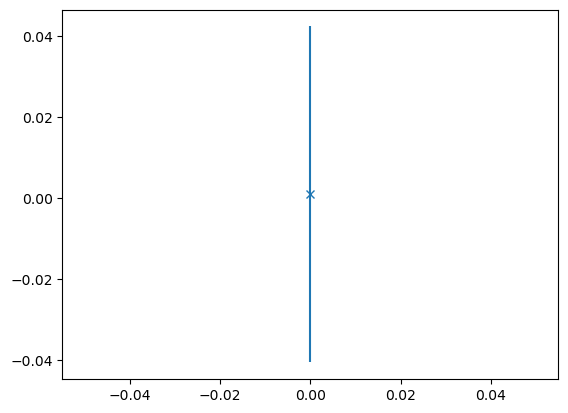

In [7]:
for i, d in enumerate( datasets_N):
    value = d.irf_model.parameters['bias'].value
    error = d.irf_model.parameters['bias'].error
    plt.errorbar(bias[i], value, yerr = error, fmt = 'x')
    

## Stat Profiles for Source Index

In [8]:
computing_norm = 1
def make_writable(stat):
    write = dict()
    for k in stat.keys():
        if k != 'fit_results':
            write[k] = [float(i) for i in stat[k]]
            
                
    return write

In [12]:
%%time
computing_index = 0

if computing_index:
    sigma = 4
    parameter_i = datasets[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_i = fit.stat_profile([datasets[0]], parameter_i, reoptimize= True)
    stat_profile_i['scale_scan'] = stat_profile_i.pop(next(iter(stat_profile_i)) )    
    with open('data/5_scan_index.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_i), file)
    
else:
    with open('data/5_scan_index.yaml') as file:
        stat_profile_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 1.21 ms, sys: 850 µs, total: 2.06 ms
Wall time: 2.6 ms


In [13]:
%%time
computing_index_N = 0
if computing_index_N:
    sigma = 4
    parameter_i = datasets_N[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_N_i = fit.stat_profile([datasets_N[0]], parameter_i, reoptimize = True)
    stat_profile_N_i['scale_scan'] = stat_profile_N_i.pop(next(iter(stat_profile_N_i)) )    
    
    with open('data/5_scan_index_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_i), file)
    
else:
    with open('data/5_scan_index_N.yaml') as file:
        stat_profile_N_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 0 ns, sys: 4.91 ms, total: 4.91 ms
Wall time: 11 ms


In [14]:
import sys
sys.path.append(config['local']['path']+'/nuisance_summary/Eff_area')
import upper_limit_18_02

In [15]:
color_standard = 'crimson'; color_standard_e = 'palevioletred'  #mediumvioletred
color_nui = 'navy'; color_nui_e = 'cornflowerblue'
color_input = 'darkorange'
color_rnd = 'darkgreen'


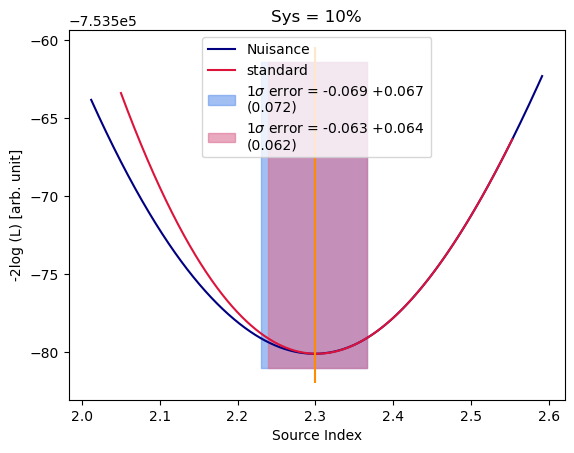

In [26]:
fig = plt.figure()
ll_N_a = stat_profile_N_i.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance", color = color_nui)


ll_a = stat_profile_i.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard", color = color_standard)

index_err = datasets[0].models[0].parameters['index'].error
index_err_N = datasets_N[0].models[0].parameters['index'].error




min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.6, 
                label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({index_err_N:.2})'
                , color = color_nui_e)
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.6, 
                label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({index_err:.2})'
                , color = color_standard_e)

ylim = ax.get_ylim()
ax.vlines(2.3, ylim[0], ylim[1], color = color_input)

plt.xlabel("Source Index")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = 10%")

fig.savefig("plots/5_stat_scan_index.png")

## Stat Profiles for Source Signal

In [19]:
%%time
computing_amplitude = 0

if computing_amplitude:
    sigma = 3
    parameter_a = datasets[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_a = fit.stat_profile([datasets[0]], parameter_a, reoptimize= True)
    stat_profile_a['scale_scan'] = stat_profile_a.pop(next(iter(stat_profile_a)) )    
    with open('data/5_scan_amplitude.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_a), file)
    
else:
    with open('data/5_scan_amplitude.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 4.65 ms, sys: 398 µs, total: 5.05 ms
Wall time: 4.77 ms


In [20]:
%%time
if computing_amplitude:
    sigma = 3
    parameter_a = datasets_N[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_N_a = fit.stat_profile([datasets_N[0]], parameter_a, reoptimize = True)
    stat_profile_N_a['scale_scan'] = stat_profile_N_a.pop(next(iter(stat_profile_N_a)) )    
    
    with open('data/5_scan_amplitude_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_a), file)
    
else:
    with open('data/5_scan_amplitude_N.yaml') as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 1.91 ms, sys: 1.2 ms, total: 3.11 ms
Wall time: 9.71 ms


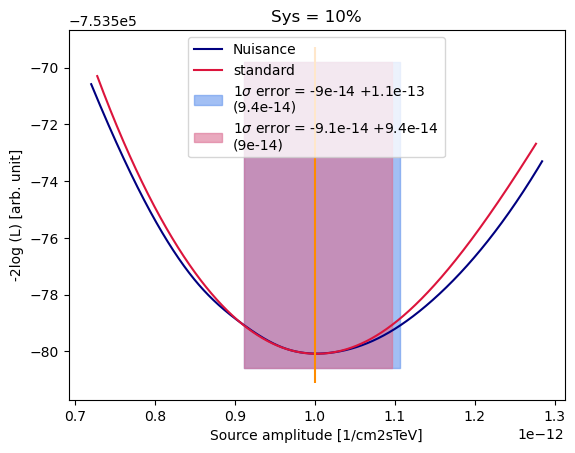

In [24]:
fig = plt.figure()
ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance",color = color_nui)


ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard", color = color_standard)

amplitude_err = datasets[0].models[0].parameters['amplitude'].error
amplitude_err_N = datasets_N[0].models[0].parameters['amplitude'].error



min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.6, 
                label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err_N:.2})'
                , color = color_nui_e)
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.6, 
                label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err:.2})'
                , color = color_standard_e)


plt.xlabel("Source amplitude [1/cm2sTeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = 10%")
ylim = ax.get_ylim()
ax.vlines(1e-12, ylim[0], ylim[1], color = color_input)
fig.savefig("plots/5_stat_scan_amplitude.png")